<a href="https://colab.research.google.com/github/armanhak/PySpark/blob/main/Pyspark_eda_clustering_Vehicle_Collisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Настроиваем PySpark в колабе

In [1]:
# !pip install haversine
# https://www.m24.ru/news/gorod/17102019/93717
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

In [ ]:
# %%time
# !apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install haversine
# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql.functions import monotonically_increasing_id, row_number, year, to_date, col, lit, isnan, when, count, udf, array
from pyspark.sql.window import Window
from pyspark.sql.types import DateType, IntegerType, FloatType

from pyspark.sql import SparkSession
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc  = spark.sparkContext

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from tqdm import tqdm
from haversine import haversine
from plotly.subplots import make_subplots
import plotly.graph_objects as go
filterwarnings('ignore')

Подключимся к диску

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<b> Schema </b>
<img src="img.png">

### PERSON

In [ ]:
%%time
##данные https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
person = spark.read.csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Person.csv', header=True)
print((person.count(), len(person.columns)))

(4129250, 21)
CPU times: user 3.35 ms, sys: 1.07 ms, total: 4.42 ms
Wall time: 3.59 s


In [ ]:
person.columns

['UNIQUE_ID',
 'COLLISION_ID',
 'CRASH_DATE',
 'CRASH_TIME',
 'PERSON_ID',
 'PERSON_TYPE',
 'PERSON_INJURY',
 'VEHICLE_ID',
 'PERSON_AGE',
 'EJECTION',
 'EMOTIONAL_STATUS',
 'BODILY_INJURY',
 'POSITION_IN_VEHICLE',
 'SAFETY_EQUIPMENT',
 'PED_LOCATION',
 'PED_ACTION',
 'COMPLAINT',
 'PED_ROLE',
 'CONTRIBUTING_FACTOR_1',
 'CONTRIBUTING_FACTOR_2',
 'PERSON_SEX']

In [ ]:
from pyspark.sql.types import DateType, IntegerType
from pyspark.sql.functions import year, to_date, col, lit, isnan, when, count

In [ ]:
# CRASH DATE + TIME
person = person.withColumn('CRASH_DATE', to_date(col('CRASH_DATE'), 'MM/dd/yyyy'))
person = person.withColumn('CRASH_TIME', to_date(col('CRASH_TIME'), 'MM/dd/yyyy'))
person = person.filter(col('CRASH_DATE') > to_date(lit('2016-01-01')))

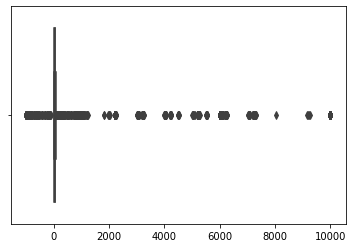

In [ ]:
sns.boxplot(data_viz.values)

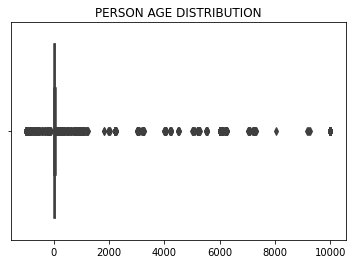

Q_01:0.0, Q_99:80.0


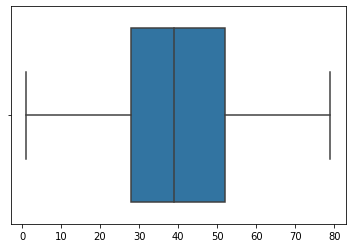

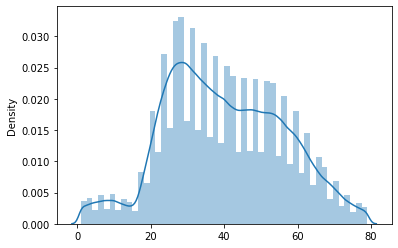

In [ ]:
person = person.withColumn('PERSON_AGE', person['PERSON_AGE'].cast('int'))
data_viz = person.select('PERSON_AGE').toPandas()
plt.title('PERSON AGE DISTRIBUTION')
sns.boxplot(data_viz.values)
plt.show()

q_01 = person.approxQuantile('PERSON_AGE', [0.01], 0.001)[0]
q_99 = person.approxQuantile('PERSON_AGE', [0.99], 0.001)[0]
print('Q_01:{}, Q_99:{}'.format(q_01, q_99))
person = person.filter((col('PERSON_AGE') > q_01) & (col('PERSON_AGE') < q_99))
q_25 = person.approxQuantile('PERSON_AGE', [0.25], 0.001)[0]
q_75 = person.approxQuantile('PERSON_AGE', [0.75], 0.001)[0]
iqr = q_75 - q_25
person = person.filter((col('PERSON_AGE') > q_25 - 1.5*iqr) & (col('PERSON_AGE') < q_75 + 1.5 * iqr))

data_viz = person.select('PERSON_AGE').toPandas()
sns.boxplot(data_viz.values)
plt.show()
sns.distplot(data_viz.values);
plt.show()

In [ ]:
# POSITION_IN_VEHICLE
filter_positions = ['Middle rear seat, or passenger lying across a seat', 'Driver',
                    'Middle front seat, or passenger lying across a seat',
                    'Front passenger, if two or more persons, including the driver, are in the front seat',
                    'Left rear passenger, or rear passenger on a bicycle, motorcycle, snowmobile',
                    'Right rear passenger or motorcycle sidecar passenger', None]
person = person.filter((col('POSITION_IN_VEHICLE').isin(filter_positions)) | (col('POSITION_IN_VEHICLE').isNull()))
person = person.withColumn('POSITION_IN_VEHICLE', when((person['POSITION_IN_VEHICLE'] != 'Driver') & 
                                                       (person['POSITION_IN_VEHICLE'].isNull()==False),
                                                       'Not a driver').otherwise(person['POSITION_IN_VEHICLE']))
person.groupby('POSITION_IN_VEHICLE').count().orderBy('count').collect()

[Row(POSITION_IN_VEHICLE='Not a driver', count=491025),
 Row(POSITION_IN_VEHICLE=None, count=992636),
 Row(POSITION_IN_VEHICLE='Driver', count=1452767)]

In [ ]:
# SAFETY_EQUIPMENT
safety_not = '-'
safety_nan = ['Unknown', 'None']
person = person.withColumn('SAFETY_EQUIPMENT', when(person['SAFETY_EQUIPMENT'] == '-',
                                                    'NOT').otherwise(person['SAFETY_EQUIPMENT']))
person = person.withColumn('SAFETY_EQUIPMENT', when(person['SAFETY_EQUIPMENT'].isin(safety_nan),
                                                    None).otherwise(person['SAFETY_EQUIPMENT']))
person = person.withColumn('SAFETY_EQUIPMENT', when((person['SAFETY_EQUIPMENT']!='NOT')&
                                                    (person['SAFETY_EQUIPMENT'].isNull()==False),
                                                    'YES').otherwise(person['SAFETY_EQUIPMENT']))
person = person.withColumn('SAFETY_EQUIPMENT', when(person['SAFETY_EQUIPMENT'].isNull(),
                                                    None).otherwise(person['SAFETY_EQUIPMENT']))
person.groupby('SAFETY_EQUIPMENT').count().orderBy('count').collect()

[Row(SAFETY_EQUIPMENT='NOT', count=2895),
 Row(SAFETY_EQUIPMENT=None, count=1347641),
 Row(SAFETY_EQUIPMENT='YES', count=1585892)]

In [ ]:
# PERSON SEX
person = person.withColumn('PERSON_SEX', when(person['PERSON_SEX'] == 'U', None).otherwise(person['PERSON_SEX']))
person.groupby('PERSON_SEX').count().orderBy('count').collect()

[Row(PERSON_SEX=None, count=18568),
 Row(PERSON_SEX='F', count=962122),
 Row(PERSON_SEX='M', count=1955738)]

In [ ]:
# drop columns
person = person.drop('EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
                     'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2', 'PED_ROLE', 'PERSON_TYPE', 'PERSON_INJURY')
print((person.count(), len(person.columns)))

(2936428, 10)


In [ ]:
# drop nans
person = person.filter(col('PERSON_ID').isNull()==False)
person = person.filter(col('VEHICLE_ID').isNull()==False)
person = person.filter(col('PERSON_SEX').isNull()==False)
# fill nans
person = person.fillna('NULL')

In [ ]:
# count nans
person.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in person.columns if c not in ['CRASH_DATE', 'CRASH_TIME', 'year']]).toPandas()

,UNIQUE_ID,COLLISION_ID,PERSON_ID,VEHICLE_ID,PERSON_AGE,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PERSON_SEX
0,0,0,0,0,0,0,0,0


In [ ]:
person.describe()

DataFrame[summary: string, UNIQUE_ID: string, COLLISION_ID: string, PERSON_ID: string, VEHICLE_ID: string, PERSON_AGE: string, POSITION_IN_VEHICLE: string, SAFETY_EQUIPMENT: string, PERSON_SEX: string]

In [ ]:
# spark..csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Person.csv', header=True)
%%time
person\
   .repartition(1)\
   .write.format("com.databricks.spark.csv")\
   .option("header", "true")\
   .save(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Person_prep.csv')

CPU times: user 18.1 ms, sys: 710 µs, total: 18.8 ms
Wall time: 1min 34s


In [ ]:
person  = spark.read.csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Person_prep.csv', header=True)


### VEHICLES

In [ ]:
%%time
vehicles = spark.read.csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Vehicles.csv', header=True)
print((vehicles.count(), len(vehicles.columns)))

(3473386, 25)
CPU times: user 4.9 ms, sys: 107 µs, total: 5.01 ms
Wall time: 3.48 s


In [ ]:
vehicles.columns

['UNIQUE_ID',
 'COLLISION_ID',
 'CRASH_DATE',
 'CRASH_TIME',
 'VEHICLE_ID',
 'STATE_REGISTRATION',
 'VEHICLE_TYPE',
 'VEHICLE_MAKE',
 'VEHICLE_MODEL',
 'VEHICLE_YEAR',
 'TRAVEL_DIRECTION',
 'VEHICLE_OCCUPANTS',
 'DRIVER_SEX',
 'DRIVER_LICENSE_STATUS',
 'DRIVER_LICENSE_JURISDICTION',
 'PRE_CRASH',
 'POINT_OF_IMPACT',
 'VEHICLE_DAMAGE',
 'VEHICLE_DAMAGE_1',
 'VEHICLE_DAMAGE_2',
 'VEHICLE_DAMAGE_3',
 'PUBLIC_PROPERTY_DAMAGE',
 'PUBLIC_PROPERTY_DAMAGE_TYPE',
 'CONTRIBUTING_FACTOR_1',
 'CONTRIBUTING_FACTOR_2']

In [ ]:
# CRASH DATE + TIME
vehicles = vehicles.withColumn('CRASH_DATE', to_date(col('CRASH_DATE'), 'MM/dd/yyyy'))
vehicles = vehicles.withColumn('CRASH_TIME', to_date(col('CRASH_TIME'), 'MM/dd/yyyy'))
vehicles = vehicles.filter(col('CRASH_DATE') > to_date(lit('2016-01-01')))

In [ ]:
# STATE REGISTRATION
vehicles = vehicles.withColumn('STATE_REGISTRATION', when((vehicles['STATE_REGISTRATION']!='NY')
                                              &(vehicles['STATE_REGISTRATION'].isNull()==False),
                                               'NOT NY').otherwise(vehicles['STATE_REGISTRATION']))
vehicles.groupby('STATE_REGISTRATION').count().orderBy('count').collect()

[Row(STATE_REGISTRATION=None, count=173289),
 Row(STATE_REGISTRATION='NOT NY', count=315369),
 Row(STATE_REGISTRATION='NY', count=1536626)]

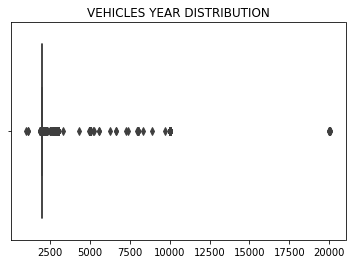

Q_01:1996.0, Q_99:2019.0


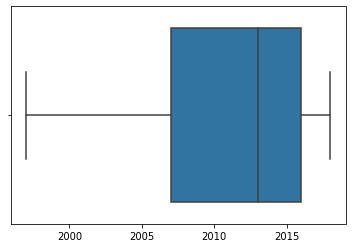

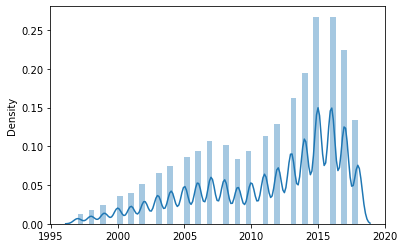

CPU times: user 13.1 s, sys: 357 ms, total: 13.4 s
Wall time: 1min 27s


In [ ]:
%%time
vehicles = vehicles.withColumn('VEHICLE_YEAR', vehicles['VEHICLE_YEAR'].cast('int'))
data_viz = vehicles.select('VEHICLE_YEAR').toPandas()
plt.title('VEHICLES YEAR DISTRIBUTION')
sns.boxplot(data_viz.values)
plt.show()

q_01 = vehicles.approxQuantile('VEHICLE_YEAR', [0.01], 0.001)[0]
q_99 = vehicles.approxQuantile('VEHICLE_YEAR', [0.99], 0.001)[0]
print('Q_01:{}, Q_99:{}'.format(q_01, q_99))
vehicles = vehicles.filter((col('VEHICLE_YEAR') > q_01) & (col('VEHICLE_YEAR') < q_99))
q_25 = vehicles.approxQuantile('VEHICLE_YEAR', [0.25], 0.001)[0]
q_75 = vehicles.approxQuantile('VEHICLE_YEAR', [0.75], 0.001)[0]
iqr = q_75 - q_25
vehicles = vehicles.filter((col('VEHICLE_YEAR') > q_25 - 1.5*iqr) & (col('VEHICLE_YEAR') < q_75 + 1.5 * iqr))

data_viz = vehicles.select('VEHICLE_YEAR').toPandas()
sns.boxplot(data_viz.values)
plt.show()
sns.distplot(data_viz.values);
plt.show()

# ПОСЧИТАТЬ ВОЗРАСТ НА МОМЕНТ АВАРИИ
vehicles = vehicles.withColumn('year', year('CRASH_DATE'))
vehicles = vehicles.filter(col('year') >= col('VEHICLE_YEAR'))
vehicles = vehicles.withColumn('VEHICLE_AGE', col('year') - col('VEHICLE_YEAR'))

In [ ]:
# DRIVER SEX
vehicles = vehicles.withColumn('DRIVER_SEX', when(vehicles['DRIVER_SEX'] == 'U',
                                                  None).otherwise(vehicles['DRIVER_SEX']))
vehicles.groupby('DRIVER_SEX').count().orderBy('count').collect()

[Row(DRIVER_SEX=None, count=248350),
 Row(DRIVER_SEX='F', count=366269),
 Row(DRIVER_SEX='M', count=1022412)]

In [ ]:
# PRE CASH
drop_values = ['Other*', 'Starting in Traffic', 'Avoiding Object in Roadway', 'Police Pursuit',
               'Making Left Turn on Red', 'Making Right Turn on Red']
vehicles = vehicles.filter(col('PRE_CRASH').isin(drop_values) == False)
vehicles = vehicles.filter(col('PRE_CRASH').isNull() == False)
vehicles.groupby('PRE_CRASH').count().orderBy('count').collect()

[Row(PRE_CRASH='Passing', count=13140),
 Row(PRE_CRASH='Making U Turn', count=13974),
 Row(PRE_CRASH='Entering Parked Position', count=22766),
 Row(PRE_CRASH='Merging', count=28643),
 Row(PRE_CRASH='Starting from Parking', count=28805),
 Row(PRE_CRASH='Changing Lanes', count=52304),
 Row(PRE_CRASH='Backing', count=56202),
 Row(PRE_CRASH='Slowing or Stopping', count=63254),
 Row(PRE_CRASH='Stopped in Traffic', count=84075),
 Row(PRE_CRASH='Making Right Turn', count=84625),
 Row(PRE_CRASH='Making Left Turn', count=100164),
 Row(PRE_CRASH='Parked', count=284861),
 Row(PRE_CRASH='Going Straight Ahead', count=775315)]

In [ ]:
# VEHICLE DAMAGE
drop_values = ['Other', 'Demolished', 'Overturned', 'Roof', 'Undercarriage', 'Trailer']
vehicles = vehicles.filter(col('VEHICLE_DAMAGE').isin(drop_values) == False)
vehicles = vehicles.filter(col('VEHICLE_DAMAGE').isNull() == False)
vehicles.groupby('VEHICLE_DAMAGE').count().orderBy('count').collect()

[Row(VEHICLE_DAMAGE='Right Rear Bumper', count=61040),
 Row(VEHICLE_DAMAGE='Right Rear Quarter Panel', count=66441),
 Row(VEHICLE_DAMAGE='Right Side Doors', count=79147),
 Row(VEHICLE_DAMAGE='Left Rear Bumper', count=85855),
 Row(VEHICLE_DAMAGE='Left Side Doors', count=92283),
 Row(VEHICLE_DAMAGE='Left Rear Quarter Panel', count=94478),
 Row(VEHICLE_DAMAGE='Right Front Quarter Panel', count=116112),
 Row(VEHICLE_DAMAGE='Left Front Quarter Panel', count=118873),
 Row(VEHICLE_DAMAGE='No Damage', count=126690),
 Row(VEHICLE_DAMAGE='Right Front Bumper', count=157836),
 Row(VEHICLE_DAMAGE='Left Front Bumper', count=171786),
 Row(VEHICLE_DAMAGE='Center Back End', count=172800),
 Row(VEHICLE_DAMAGE='Center Front End', count=230332)]

In [ ]:
# drop columns
vehicles = vehicles.drop('VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'VEHICLE_YEAR', 'TRAVEL_DIRECTION',
                         'VEHICLE_OCCUPANTS', 'DRIVER_LICENSE_STATUS', 'DRIVER_LICENSE_JURISDICTION',
                         'VEHICLE_DAMAGE_1', 'VEHICLE_DAMAGE_2', 'VEHICLE_DAMAGE_3', 'PUBLIC_PROPERTY_DAMAGE',
                         'PUBLIC_PROPERTY_DAMAGE_TYPE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2', 'POINT_OF_IMPACT')
print((vehicles.count(), len(vehicles.columns)))

(1573673, 11)


In [ ]:
# drop nans
vehicles = vehicles.filter(col('STATE_REGISTRATION').isNull()==False)
vehicles = vehicles.filter(col('PRE_CRASH').isNull()==False)
vehicles = vehicles.filter(col('VEHICLE_DAMAGE').isNull()==False)
# fill nans
vehicles = vehicles.fillna('NULL')

In [ ]:
# count nans
vehicles.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in vehicles.columns if c not in ['CRASH_DATE', 'CRASH_TIME', 'year']]).toPandas()

,UNIQUE_ID,COLLISION_ID,VEHICLE_ID,STATE_REGISTRATION,DRIVER_SEX,PRE_CRASH,VEHICLE_DAMAGE,VEHICLE_AGE
0,0,0,0,0,0,0,0,0


In [ ]:
# spark..csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Person.csv', header=True)
%%time
vehicles\
   .repartition(1)\
   .write.format("com.databricks.spark.csv")\
   .option("header", "true")\
   .save(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Vehicles_prep.csv')

CPU times: user 10.8 ms, sys: 1.28 ms, total: 12.1 ms
Wall time: 59.7 s


### CRASHES

In [ ]:
%%time
crashes = spark.read.csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv', header=True)
print((crashes.count(), len(crashes.columns)))

(1734987, 29)
CPU times: user 3.66 ms, sys: 1.84 ms, total: 5.49 ms
Wall time: 8.07 s


In [ ]:
crashes.columns

['CRASH DATE',
 'CRASH TIME',
 'BOROUGH',
 'ZIP CODE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'ON STREET NAME',
 'CROSS STREET NAME',
 'OFF STREET NAME',
 'NUMBER OF PERSONS INJURED',
 'NUMBER OF PERSONS KILLED',
 'NUMBER OF PEDESTRIANS INJURED',
 'NUMBER OF PEDESTRIANS KILLED',
 'NUMBER OF CYCLIST INJURED',
 'NUMBER OF CYCLIST KILLED',
 'NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 1',
 'CONTRIBUTING FACTOR VEHICLE 2',
 'CONTRIBUTING FACTOR VEHICLE 3',
 'CONTRIBUTING FACTOR VEHICLE 4',
 'CONTRIBUTING FACTOR VEHICLE 5',
 'COLLISION_ID',
 'VEHICLE TYPE CODE 1',
 'VEHICLE TYPE CODE 2',
 'VEHICLE TYPE CODE 3',
 'VEHICLE TYPE CODE 4',
 'VEHICLE TYPE CODE 5']

In [ ]:
crashes.show(3)

+----------+----------+--------+--------+---------+---------+--------------------+--------------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+--------------------+--------------------+-------------------+-------------------+-------------------+----------+
|CRASH DATE|CRASH TIME| BOROUGH|ZIP CODE| LATITUDE|LONGITUDE|            LOCATION|      ON STREET NAME|CROSS STREET NAME|     OFF STREET NAME|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONTRIBUTIN

In [ ]:
# CRASH DATE + TIME
crashes = crashes.withColumn('CRASH DATE', to_date(col('CRASH DATE'), 'MM/dd/yyyy'))
# crashes = crashes.withColumn('CRASH TIME', to_date(col('CRASH TIME'), 'MM/dd/yyyy'))
crashes = crashes.withColumn('year', col('CRASH DATE').alias('year'))
crashes = crashes.filter(col('year') > to_date(lit('2016-01-01')))

In [ ]:
%%time
# BOROUGH
pd_data = crashes.select('BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME').toPandas()
for borough in ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND']:
    temp = pd_data.loc[pd_data['BOROUGH']==borough, 'ON STREET NAME'].values
    pd_data.loc[(pd_data['BOROUGH'].isna())
               &(pd_data['ON STREET NAME'].isin(temp)), 'BOROUGH'] = borough
for borough in ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND']:
    temp = pd_data.loc[pd_data['BOROUGH']==borough, 'CROSS STREET NAME'].values
    pd_data.loc[(pd_data['BOROUGH'].isna())
               &(pd_data['CROSS STREET NAME'].isin(temp)), 'BOROUGH'] = borough
for borough in ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND']:
    temp = pd_data.loc[pd_data['BOROUGH']==borough, 'OFF STREET NAME'].values
    pd_data.loc[(pd_data['BOROUGH'].isna())
               &(pd_data['OFF STREET NAME'].isin(temp)), 'BOROUGH'] = borough
print('\n', pd_data['BOROUGH'].value_counts(dropna=False))


 BROOKLYN         381034
QUEENS           264475
MANHATTAN        180030
BRONX            145083
STATEN ISLAND     35969
Name: BOROUGH, dtype: int64
CPU times: user 6.73 s, sys: 32.5 ms, total: 6.76 s
Wall time: 18.4 s


In [ ]:
%%time
pd_data = spark.createDataFrame(pd_data)
crashes = crashes.drop('BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME')
crashes = crashes.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
pd_data = pd_data.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
crashes = crashes.join(pd_data, on=["row_index"]).drop("row_index")

CPU times: user 30.5 s, sys: 67.9 ms, total: 30.6 s
Wall time: 31 s


In [ ]:
# LAT LON
def custom_haversine(lat_a, lon_a, lat_b, lon_b):
    distance = haversine((float(lat_a), float(lon_a)), (float(lat_b), float(lon_b)))
    return distance

udf_get_distance  = udf(custom_haversine)
crashes = crashes.filter((col('LATITUDE').isNull()==False)
                        &(col('LONGITUDE').isNull()==False))
crashes = crashes.withColumn('Haversine distance', udf_get_distance(crashes['LATITUDE'], crashes['LONGITUDE'],
                                                                    lit(40.730610), lit(-73.935242)))
crashes = crashes.withColumn('Haversine distance', crashes['Haversine distance'].cast(FloatType()))
crashes = crashes.filter(col('Haversine distance') <= 70)

In [ ]:
# drop nans
crashes = crashes.filter(col('NUMBER OF PERSONS INJURED').isNull()==False)
crashes = crashes.filter(col('NUMBER OF PERSONS KILLED').isNull()==False)
crashes = crashes.filter(col('CONTRIBUTING FACTOR VEHICLE 1').isNull()==False)
crashes = crashes.filter(col('LATITUDE').isNull()==False)
crashes = crashes.filter(col('LONGITUDE').isNull()==False)
# fill nans
crashes = crashes.fillna('NULL')

In [ ]:
# count nans
crashes.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in crashes.columns if c not in ['CRASH DATE', 'CRASH TIME', 'year']]).toPandas()

,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,BOROUGH,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,Haversine distance
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
crashes.count()

910370

In [ ]:
%%time
crashes\
   .repartition(1)\
   .write.format("com.databricks.spark.csv")\
   .option("header", "true")\
   .save(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes_prep.csv')

CPU times: user 34 ms, sys: 10.1 ms, total: 44.1 ms
Wall time: 1min 12s


## VISUALIZATION

### Crashes

In [ ]:
crashes.limit(3).toPandas()

,CRASH DATE,CRASH TIME,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,year,BOROUGH,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,Haversine distance
0,2019-06-04,None,11217,40.68629,-73.979095,"(40.68629, -73.979095)",0,0,0,0,0,0,0,0,Unspecified,NULL,NULL,NULL,NULL,4144943,Box Truck,NULL,NULL,NULL,NULL,2019-06-04,BROOKLYN,SCHERMERHORN STREET,FLATBUSH AVENUE,NULL,6.160357
1,2019-05-30,None,NULL,40.824066,-73.908714,"(40.824066, -73.908714)",0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NULL,NULL,NULL,4142264,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NULL,NULL,NULL,2019-05-30,BROOKLYN,3 AVENUE,NULL,NULL,10.629208
2,2019-05-28,None,11355,40.75539,-73.828285,"(40.75539, -73.828285)",0,0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NULL,NULL,NULL,4140841,Sedan,Station Wagon/Sport Utility Vehicle,NULL,NULL,NULL,2019-05-28,QUEENS,MAPLE AVENUE,MAIN STREET,NULL,9.422617


In [ ]:
%%time
data_viz = crashes.toPandas()

CPU times: user 22.9 s, sys: 1.59 s, total: 24.5 s
Wall time: 1min 56s


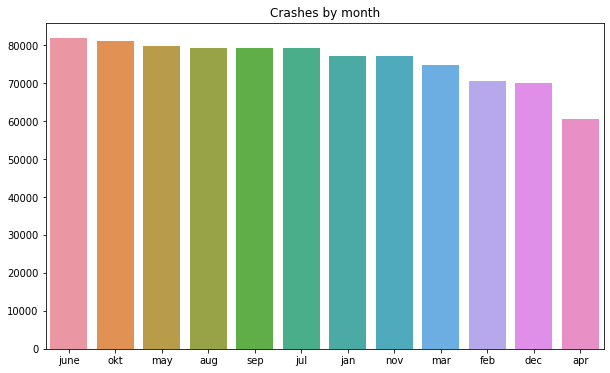

In [ ]:
data_viz['CRASH DATE'] = pd.to_datetime(data_viz['CRASH DATE'])
d = data_viz['CRASH DATE'].dt.month.value_counts()
x = d.keys().map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'june',
                  7:'jul', 8:'aug', 9:'sep', 10:'okt', 11:'nov', 12:'dec'})
y = d.values
plt.figure(figsize=(10, 6))
plt.title('Crashes by month')
sns.barplot(x, y)
pass

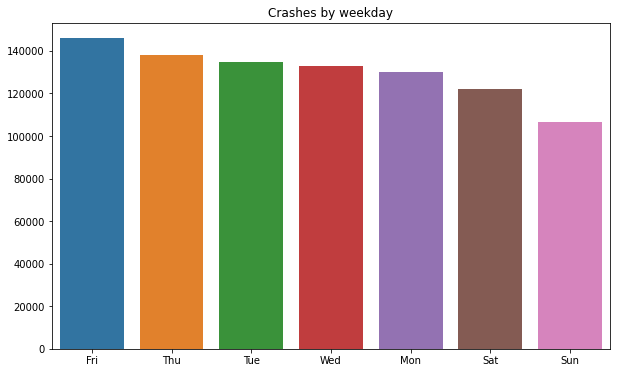

In [ ]:
d = data_viz['CRASH DATE'].dt.weekday.value_counts()
x = d.keys().map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
y = d.values
plt.figure(figsize=(10, 6))
plt.title('Crashes by weekday')
sns.barplot(x, y)
pass

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
data_viz[[i for i in data_viz.columns if 'NUMBER' in i]] = data_viz[[i for i in data_viz.columns if 'NUMBER' in i]].astype('int')
cal = calendar()
holidays = cal.holidays(start=data_viz['CRASH DATE'].min(), end=data_viz['CRASH DATE'].max())
data_viz['holidays'] = data_viz['CRASH DATE'].isin(holidays)
d = (data_viz.groupby('holidays').agg('mean') * 1000).drop('Haversine distance', axis=1)
d.round(2)

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
holidays,,,,,,,,
False,279.45,1.18,49.08,0.61,25.15,0.10,204.90,0.46
True,320.39,1.35,51.19,0.49,26.22,0.27,242.33,0.59


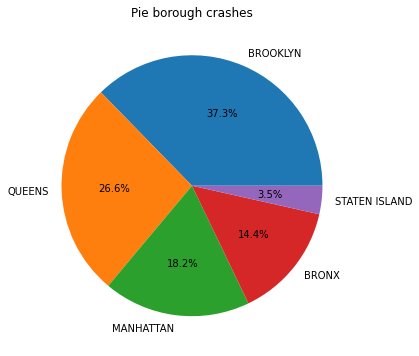

In [ ]:
d = data_viz['BOROUGH'].value_counts()
plt.figure(figsize=(10, 6))
plt.title('Pie borough crashes')
plt.pie(d, labels=d.keys(), autopct='%1.1f%%')
plt.show()

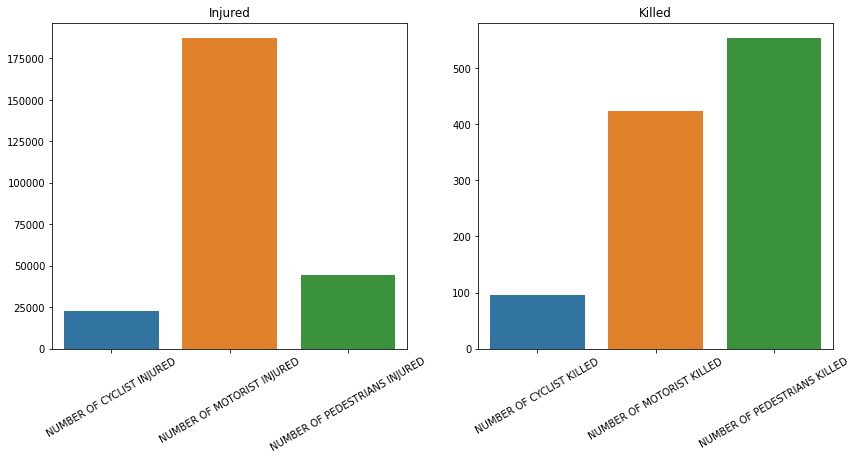

In [ ]:
injured_num = []
killed_num = []
injured_list = ['NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF PEDESTRIANS INJURED']
killed_list = ['NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED', 'NUMBER OF PEDESTRIANS KILLED']
for i in injured_list:
    temp = data_viz.loc[(data_viz[i].isna()==False)
                      &(data_viz[i]!='NULL'), i].astype(int).sum()
    injured_num.append([i, temp])
for i in killed_list:
    temp = data_viz.loc[(data_viz[i].isna()==False)
                      &(data_viz[i]!='NULL'), i].astype(int).sum()
    killed_num.append([i, temp])
injured_num = np.array(injured_num)
killed_num = np.array(killed_num)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
x1, x2 = injured_num[:, 0], killed_num[:, 0]
y1, y2 = injured_num[:, 1], killed_num[:, 1]
for tick in ax[0].get_xticklabels():
    tick.set_rotation(30)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(30)
ax[0].title.set_text('Injured')
ax[1].title.set_text('Killed')
sns.barplot(x1, y1.astype(int), ax=ax[0])
sns.barplot(x2, y2.astype(int), ax=ax[1])
plt.show()

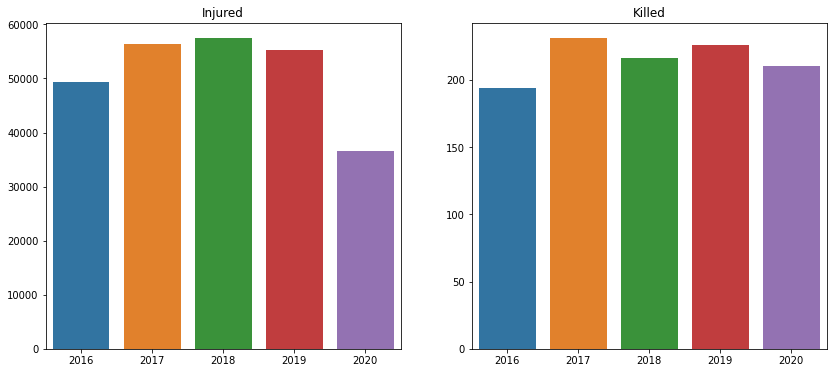

In [ ]:
years = [2016, 2017, 2018, 2019, 2020]
injured_num = []
killed_num = []
for year in years:
    temp = data_viz.loc[(data_viz['NUMBER OF PERSONS INJURED']!='NULL')
                       &(data_viz['CRASH DATE'].dt.year == year), 'NUMBER OF PERSONS INJURED'].sum()
    injured_num.append([str(year), temp])
    temp = data_viz.loc[(data_viz['NUMBER OF PERSONS KILLED']!='NULL')
                       &(data_viz['CRASH DATE'].dt.year == year), 'NUMBER OF PERSONS KILLED'].sum()
    killed_num.append([str(year), temp])
    
injured_num = np.array(injured_num)
killed_num = np.array(killed_num)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x = injured_num[:, 0], y = injured_num[:, 1].astype(int), ax=ax[0])
sns.barplot(x = killed_num[:, 0], y = killed_num[:, 1].astype(int), ax=ax[1])
ax[0].title.set_text('Injured')
ax[1].title.set_text('Killed')
plt.show()

### Person

In [ ]:
person.limit(3).toPandas()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,VEHICLE_ID,PERSON_AGE,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PERSON_SEX
0,10250662,4230235,2019-10-26,None,b5da9aa6-3230-4203-bbde-3b6f9248ac31,19141868,11,Not a driver,NULL,F
1,10253241,4231281,2019-10-25,None,871840c9-fbae-4273-9b1f-c3bdbad27e1a,19143162,29,NULL,NULL,M
2,10253976,4230620,2019-10-16,None,3983bcbc-dbd6-436f-a499-70189612dad7,19143533,24,Driver,YES,M


In [ ]:
%%time
data_viz = person.toPandas()

CPU times: user 24.5 s, sys: 4.76 s, total: 29.3 s
Wall time: 1min 20s


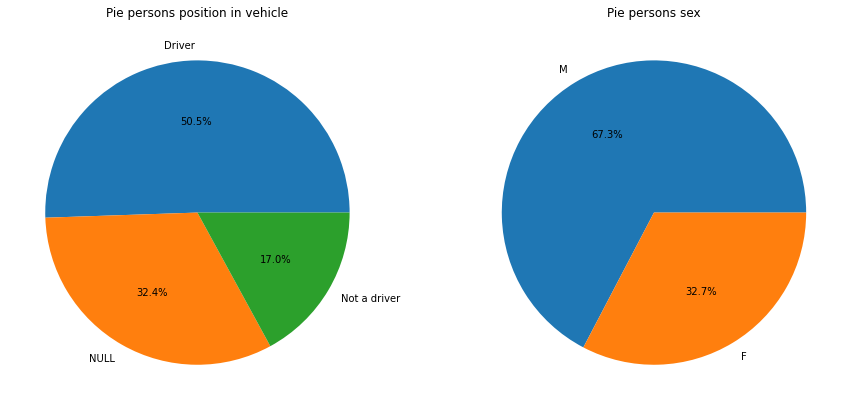

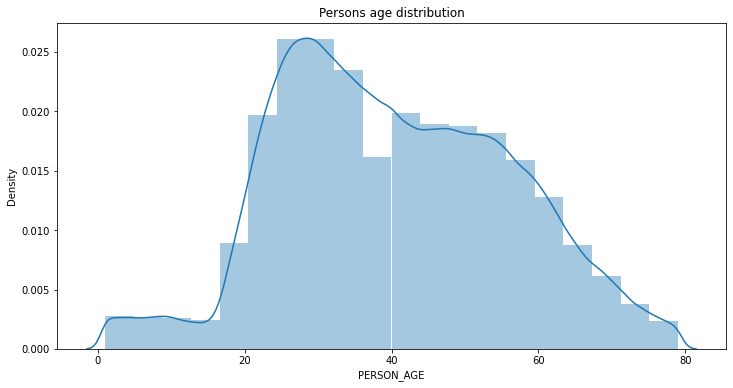

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

d = data_viz['POSITION_IN_VEHICLE'].value_counts()
ax[0].pie(d, labels=d.keys(), autopct='%1.1f%%')
ax[0].title.set_text('Pie persons position in vehicle')

d = data_viz['PERSON_SEX'].value_counts()
ax[1].pie(d, labels=d.keys(), autopct='%1.1f%%')
ax[1].title.set_text('Pie persons sex')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.title('Persons age distribution')
sns.distplot(data_viz['PERSON_AGE'], bins=20);
plt.show()

### Vehicles

In [ ]:
vehicles.limit(3).toPandas()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,VEHICLE_ID,STATE_REGISTRATION,DRIVER_SEX,PRE_CRASH,VEHICLE_DAMAGE,year,VEHICLE_AGE
0,19140121,4229438,2019-10-18,None,52ae0029-b174-40c9-9ef5-abdd5fdb2704,NOT NY,NULL,Parked,Left Front Bumper,2019,4
1,17044639,3434155,2016-05-02,None,219456,NY,M,Merging,Right Front Bumper,2016,1
2,19139564,4228846,2019-10-23,None,a6e7f188-c660-4208-b907-1833d8676d47,NY,M,Going Straight Ahead,Left Side Doors,2019,12


In [ ]:
%%time
data_viz = vehicles.toPandas()

CPU times: user 18.7 s, sys: 139 ms, total: 18.9 s
Wall time: 1min 28s


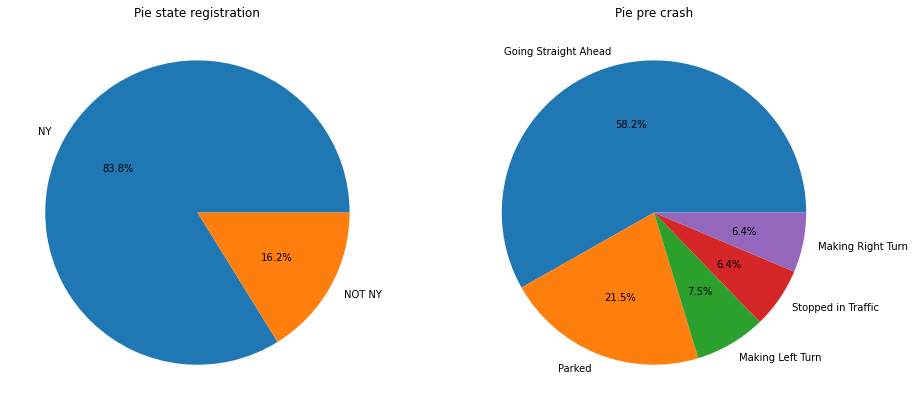

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

d = data_viz['STATE_REGISTRATION'].value_counts()
ax[0].pie(d, labels=d.keys(), autopct='%1.1f%%')
ax[0].title.set_text('Pie state registration')

d = data_viz['PRE_CRASH'].value_counts()[:5]
ax[1].pie(d, labels=d.keys(), autopct='%1.1f%%')
ax[1].title.set_text('Pie pre crash')

plt.show()

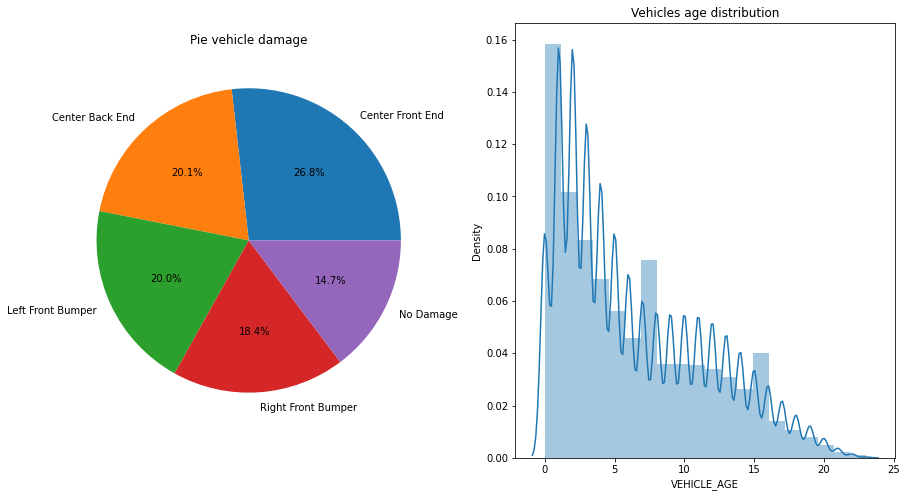

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

d = data_viz['VEHICLE_DAMAGE'].value_counts()[:5]
ax[0].pie(d, labels=d.keys(), autopct='%1.1f%%')
ax[0].title.set_text('Pie vehicle damage')

sns.distplot(data_viz['VEHICLE_AGE'], bins=20, ax=ax[1])
ax[1].title.set_text('Vehicles age distribution')
plt.show()

### Map


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoibWFrc2lta3J1Zzk2IiwiYSI6ImNrMGdqMjFwejA3azQzZHBicnFma3Rqb2sifQ.kxLV3f8yH7Vlua-eXzImpw')

In [ ]:
%%time
data_viz = crashes.toPandas()

CPU times: user 22.8 s, sys: 116 ms, total: 22.9 s
Wall time: 54.8 s


In [ ]:
# create sample
data_viz['CRASH DATE'] = pd.to_datetime(data_viz['CRASH DATE'])
data_viz['NUMBER OF PERSONS INJURED'] = data_viz['NUMBER OF PERSONS INJURED'].astype('int')
data_vis = data_viz.sample(2000)
data_vis['year'] = data_vis['CRASH DATE'].dt.year
data_vis['year'] = data_vis['year'].astype(str)
data_vis['weekday'] = data_vis['CRASH DATE'].dt.weekday
data_vis['weekday'] = data_vis['weekday'].astype(str)
data_vis['weekday'] = data_vis['weekday'].map({'0':'mon', '1':'tue', '2':'wed', '3':'thu', '4':'fri', '5':'sat', '6':'sun'})
data_vis = data_vis.sort_values(['year', 'weekday'], ascending=True)
data_vis['NUMBER OF PERSONS INJURED'] = data_vis['NUMBER OF PERSONS INJURED'] + 1
data_vis['LATITUDE'] = data_vis['LATITUDE'].astype('float')
data_vis['LONGITUDE'] = data_vis['LONGITUDE'].astype('float')

In [ ]:
# color_type
dropdown_color = widgets.Dropdown(options = ['BOROUGH', 'year', 'weekday'], description='Color')
save_color = 'BOROUGH'

def update(change):
    
    global save_color
    global save_size
    global data_vis
    
    change_color = change['owner'].options == ('BOROUGH', 'year', 'weekday')
    
    if change_color:
        save_color = change.new        
        
    # plot
    fig = px.scatter_mapbox(data_vis, lat="LATITUDE", lon="LONGITUDE",
                                color=save_color, size='NUMBER OF PERSONS INJURED')
    clear_output()
    dropdown_color.observe(update, names='value')
    display(dropdown_color)
    fig.show()
     
# first map
dropdown_color.observe(update, names='value')
display(dropdown_color)
fig = px.scatter_mapbox(data_vis, lat="LATITUDE", lon="LONGITUDE", color=save_color,
                        size='NUMBER OF PERSONS INJURED')
fig.show()

Dropdown(description='Color', index=2, options=('BOROUGH', 'year', 'weekday'), value='weekday')

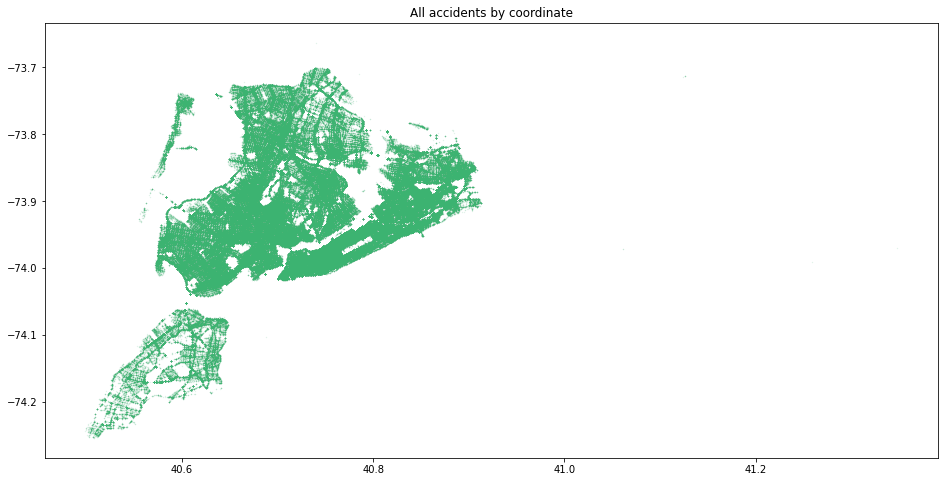

In [ ]:
# easy viz
data_viz['LATITUDE'] = data_viz['LATITUDE'].astype('float')
data_viz['LONGITUDE'] = data_viz['LONGITUDE'].astype('float')
plt.figure(figsize=(16,8))
plt.scatter(x=data_viz['LATITUDE'], y=data_viz['LONGITUDE'],
            alpha=0.2, s=0.1, color='mediumseagreen')
plt.title('All accidents by coordinate');

In [ ]:
data_viz['NUMBER OF PERSONS KILLED'] = data_viz['NUMBER OF PERSONS KILLED'].astype('int')
fig = make_subplots(rows=2,cols=1, 
                    subplot_titles=('NUMBER OF INJURED PER DAY', 'NUMBER OF KILLED PER DAY'))
cols = ['QUEENS', 'BROOKLYN', 'MANHATTAN', 'BRONX', 'STATEN ISLAND']
feat  = [i for i in data_viz.columns if 'NUMBER' in i] + ['CRASH DATE']

for i, bor in enumerate(cols):
    data_per_bor = data_viz[data_viz['BOROUGH']== bor][feat]
    data_per_bor = data_per_bor.groupby('CRASH DATE').sum()
    
    fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['NUMBER OF PERSONS INJURED'], name=bor), row=1,col=1)
    fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['NUMBER OF PERSONS KILLED'], name=bor), row=2, col=1)

fig.update_layout(template='plotly_dark', width=1000, height=800)
fig.show()

## Задачи МО

1. Сделать кластеризацию по гео-координатам аварии и выбрать оптимальные места для машин скорой помощи



Загрузим данные

In [19]:
%%time
from datetime import datetime
from pyspark.sql.types import DateType, FloatType

crashes = spark.read.csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes_prep.csv', header=True)
crashes_pd = crashes.toPandas()
# vehicles = spark.read.csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Vehicles_prep.csv', header=True)
# vehiclespd = vehicles.toPandas()
# person = spark.read.csv(r'/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Person_prep.csv', header=True)
# person_pd = person.toPandas()

# Приведем в правильный тип
todate =  udf (lambda x: datetime.strptime(x, "%Y-%m-%d"), DateType())
crashes = crashes.withColumn('CRASH DATE', todate(col('CRASH DATE')))

crashes = crashes.withColumn('LATITUDE', crashes['LATITUDE'].cast(FloatType()))
crashes = crashes.withColumn('LONGITUDE', crashes['LONGITUDE'].cast(FloatType()))

CPU times: user 16.4 s, sys: 897 ms, total: 17.3 s
Wall time: 43.4 s


In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder
#for predictors
from pyspark.ml.feature import VectorAssembler

<b>Если клатсеризация уже сделана и модели сохраненены, то можно пропустить блок k-means и переходить к osmnx-intall

### K-means

In [ ]:
from pyspark.ml.feature import VectorAssembler
start_date = '2019-04-01'
stop_date = '2019-07-01'

features =   ('LATITUDE', 'LONGITUDE') 
ASSEMBLER = VectorAssembler(inputCols=features,outputCol="features")
df = crashes.filter((col('CRASH DATE')>start_date) & (col('CRASH DATE')<stop_date))
dataset=ASSEMBLER.transform(df)
dataset = dataset.select("features")
dataset.show(5,truncate=False)

+--------------------------------------+
|features                              |
+--------------------------------------+
|[40.6862907409668,-73.97909545898438] |
|[40.824066162109375,-73.9087142944336]|
|[40.75539016723633,-73.82828521728516]|
|[40.74322509765625,-74.0086441040039] |
|[40.62593460083008,-73.9179458618164] |
+--------------------------------------+
only showing top 5 rows



Выберим данные в период от '2019-04-01' до '2019-07-01'

Сохранение и загрука векторизатора

In [ ]:
#save and load VectorAssembler
# ASSEMBLER.save(r'/content/drive/MyDrive/models/VectorAssembler')
# ASSEMBLER = VectorAssembler.load(r'/content/drive/MyDrive/models/VectorAssembler')

Обучим k-means построим график при различных кластеров

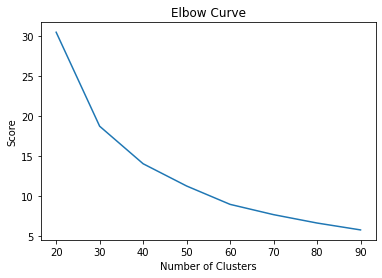

CPU times: user 347 ms, sys: 27.9 ms, total: 375 ms
Wall time: 5min 56s


In [ ]:
%%time

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
if False
    K_clusters = range(20,91,10)
    kmeans = [KMeans().setK(i).setSeed(1).setFeaturesCol("features") for i in K_clusters]
    score = [kmeans[i].fit(dataset.limit(50452)).summary.trainingCost for i in range(len(kmeans))]
    # Visualize
    plt.plot(K_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

Обучим модель на 60 кластеров

In [ ]:
%%time
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(60).setSeed(1).setFeaturesCol("features")
KMEANS_MODEL = kmeans.fit(dataset.limit(50452))
CLUSTER_CENTERS = np.array(KMEANS_MODEL.clusterCenters())
TRAIN_CLUSTERS = KMEANS_MODEL.transform(dataset).toPandas()['prediction'].tolist()

CPU times: user 732 ms, sys: 4.9 ms, total: 737 ms
Wall time: 1min 15s


Сохранение и загрузка модели

In [ ]:
#save and load KMEANS_MODEL
from pyspark.ml.clustering import KMeansModel
# KMEANS_MODEL.save(r'/content/drive/MyDrive/models/KMEANS_MODEL')
KMEANS_MODEL = KMeansModel.load(r'/content/drive/MyDrive/models/KMEANS_MODEL')#KMEANS_MODEL30

Дальше нужно выполнить  osmnx install для построения маршрутов (osmnx нужно установить после установки pyspark, чтобы не появились конфликиты с окружениями)

### osmnx install

In [ ]:
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')

In [ ]:
!./configure
!make
!make install
!pip install rtree


In [ ]:
!ldconfig
!pip install osmnx
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
import osmnx as ox

### Vizualization

Загружаем сохраненные модели 

In [35]:
global ASSEMBLER
global KMEANS_MODEL
ASSEMBLER = VectorAssembler.load(r'/content/drive/MyDrive/models/VectorAssembler')
#60 кластеров
KMEANS_MODEL = KMeansModel.load(r'/content/drive/MyDrive/models/KMEANS_MODEL')#KMEANS_MODEL30

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

start_date = '2019-04-01'
stop_date = '2019-07-01'

features =   ('LATITUDE', 'LONGITUDE') 
df = crashes.filter((col('CRASH DATE')>start_date) & (col('CRASH DATE')<stop_date))
dataset=ASSEMBLER.transform(df)
dataset = dataset.select("features")
dataset.show(5,truncate=False)

+--------------------------------------+
|features                              |
+--------------------------------------+
|[40.6862907409668,-73.97909545898438] |
|[40.824066162109375,-73.9087142944336]|
|[40.75539016723633,-73.82828521728516]|
|[40.74322509765625,-74.0086441040039] |
|[40.62593460083008,-73.9179458618164] |
+--------------------------------------+
only showing top 5 rows



In [39]:
global CLUSTER_CENTERS
global TRAIN_CLUSTERS
global LABEL_CENTER_DICT
CLUSTER_CENTERS = np.array(KMEANS_MODEL.clusterCenters())
TRAIN_CLUSTERS = KMEANS_MODEL.transform(dataset).toPandas()['prediction'].tolist()

#Создадим словарь LABEL_CENTER_DICT (по номеру кластера возвращает центр кластера) и функцию coordinateToCluster (принимает на вход координаты,кластеризует и возвращает номер кластера)
LABEL_CENTER_DICT = dict(zip(range(KMEANS_MODEL.getK()),CLUSTER_CENTERS))
def coordinateToCluster(coord):
    global ASSEMBLER
    global KMEANS_MODEL
    e =spark.createDataFrame([[ coord[0] , coord[1] ]],['LATITUDE', 'LONGITUDE'])
    e = ASSEMBLER.transform(e)
    cl_num = KMEANS_MODEL.transform(e).select('prediction').collect()[0]["prediction"]
    return cl_num
LABEL_CENTER_DICT[coordinateToCluster([40.7557071 , -73.99273121])]

array([ 40.7557071 , -73.99273121])

In [23]:
x=df.select('LATITUDE').toPandas()['LATITUDE']
y=df.select('LONGITUDE').toPandas()['LONGITUDE']

визуализируем на matplotlib

CPU times: user 28.8 ms, sys: 0 ns, total: 28.8 ms
Wall time: 29.8 ms


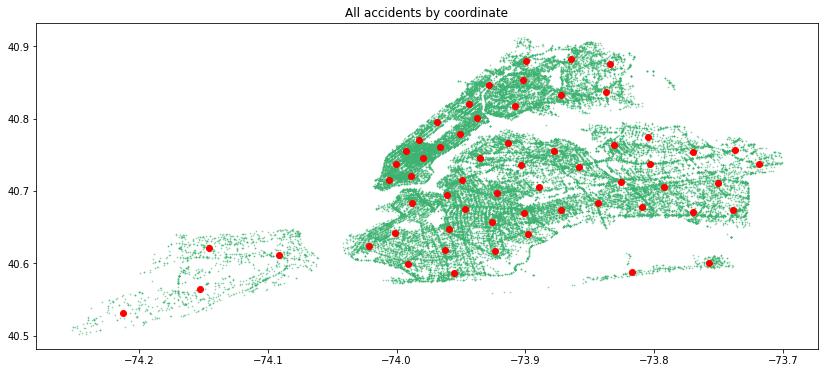

In [44]:
%%time
plt.figure(figsize=(14,6))
plt.scatter(x=y,
            y=x,
            alpha=0.5, 
            s=0.5, 
            color='mediumseagreen')
plt.scatter(x=CLUSTER_CENTERS[:, 1],
            y=CLUSTER_CENTERS[:, 0],
            c='red')
plt.title('All accidents by coordinate');

In [45]:
%%time
# G = ox.graph_from_place('New York, EN', network_type='drive')
# ox.save_graphml(G, filepath=r'/content/drive/MyDrive/models/NewYork_driverNetwork.graphml')
global G
G = ox.load_graphml(r'/content/drive/MyDrive/models/NewYork_driverNetwork.graphml')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

CPU times: user 21.8 s, sys: 265 ms, total: 22 s
Wall time: 22.1 s


In [46]:
def get_route(crash_coord):
    """Для заданного координата определяет центр кластера и возвращает маршрут"""
    global G
    global LABEL_CENTER_DICT
    center_coord = LABEL_CENTER_DICT[coordinateToCluster(crash_coord)]
    orig = ox.get_nearest_node(G, crash_coord)
    dest = ox.get_nearest_node(G, center_coord)
    route = ox.shortest_path(G, orig, dest, weight='travel_time')
    return route
def get_dist_and_time(route):
    """По маршируту возвращет расстояние в км и в минутах"""
    global G
    edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
    dist_km = round(sum(edge_lengths)/1000,1)
    time_parts = ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')

    time_min = round(sum(time_parts)/60, 1)
    return f'{dist_km} km, {time_min} min'

Программа для нахождения ближайщего кластера и построения маршрута

In [47]:
import plotly.express as px
mapbox_access_token = 'pk.eyJ1IjoibWFrc2lta3J1Zzk2IiwiYSI6ImNrMGdqMjFwejA3azQzZHBicnFma3Rqb2sifQ.kxLV3f8yH7Vlua-eXzImpw'
import ipywidgets as widgets
from IPython.display import display, clear_output
def main():
    global G
    global TRAIN_CLUSTERS
    global CLUSTER_CENTERS
    input_address = widgets.Text(placeholder='address of the accident')
    zoom = 1
    def update(change): 
        route_coords_ = ''
        crash_address = change.new
        crash_coord = ox.geocode(crash_address)
        route = get_route(crash_coord)
        route_coords_ = [[str(G.nodes[r]['y']) for r in route],[str(G.nodes[r]['x']) for r in route] ]        
        # plot
        fig.update_layout(
            mapbox=dict(
                center =go.layout.mapbox.Center(
                    lat=crash_coord[0],
                    lon=crash_coord[1]
                    ),
                    zoom=14                
                ),           
        )    
        if route_coords_:
            fig.add_scattermapbox(
                mode = "lines",
                line = {'width':5},
                lat=route_coords_[0],
                lon=route_coords_[1],
                marker={'color':'green','size':20},
                name  = 'Shortest path from ambulance to crash',               
                )    
        clear_output()
        input_address.observe(update, names='value')
        display(input_address)
        fig.show()
        print(get_dist_and_time(route))

    input_address.observe(update, names='value')
    display(input_address)
    fig = go.Figure(go.Scattermapbox(
            lat=x,
            lon=y,
            name='Crashe coordinates',
            mode='markers',
            marker={'opacity':0.2,
                    'color':TRAIN_CLUSTERS,#'mediumseagreen',
                    'size':7},    
        ))
    fig.update_layout(
        width=1600,height=700,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            center=go.layout.mapbox.Center(
                lat=40.72,
                lon=-73.92
            ),
            pitch=0,
            zoom=9.5,       
        )
    )
    fig.add_scattermapbox(lat=CLUSTER_CENTERS[:, 0],
                        lon=CLUSTER_CENTERS[:, 1],
                        marker=go.scattermapbox.Marker(size=9,#color='red',
                                                        symbol='bus'
                                                        ),  
                        name  = 'Ambulance'
                        )

    fig.show()
    

#### Main

In [48]:
main()
#скопируй один из адресов (без кавичек) в адресном поле
    # crash_addresses = ['47 W 13th St, New York, NY 10011, USA',
    #                    'Canarsie, Brooklyn, NY 11236, USA',
    #                    '188th St,Fresh Meadows, NY 11365, USA',
    #                    '26 Ulmer St, Queens, NY 11354, USA'
    #                    ]     

Text(value='26 Ulmer St, Queens, NY 11354, USA', placeholder='address of the accident')

1.5 km, 2.2 min


#### Анализ кластеров

In [49]:
import pandas as pd
res_df = pd.read_csv(r'/content/drive/MyDrive/res_df_2019_04_to_2019_07.csv')

Среднее кол-во аварии за день в каждом кластере

Text(0, 0.5, 'Кол-во аварии')

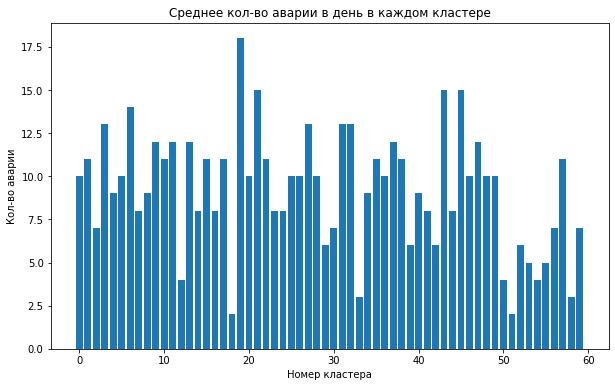

In [52]:
point_count = round(res_df['prediction'].value_counts()/90).reset_index()
# plt.bar(round(res_df['prediction'].value_counts()/90))
plt.figure(figsize=(10,6))
plt.bar(x=point_count['index'], height=point_count['prediction'] )
plt.title('Среднее кол-во аварии в день в каждом кластере')
# plt.yticks(range(1,19))
plt.xlabel('Номер кластера')
plt.ylabel('Кол-во аварии')

Среднее время (в минутах) маршрута от каждой до центра кластера внутри каждого кластера

Text(0, 0.5, 'время, мин')

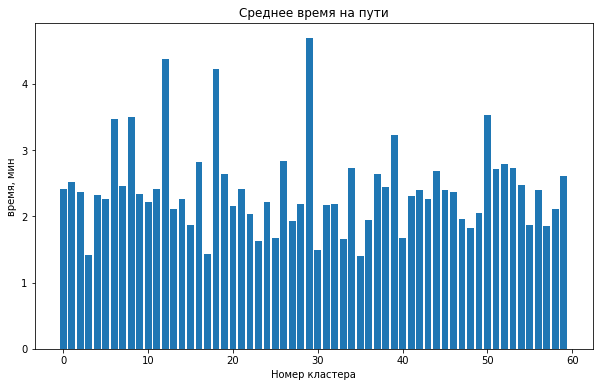

In [50]:
mean_max_time = res_df.groupby(by = 'prediction')['dist_minutes'].agg(['mean', 'max']).reset_index()
plt.figure(figsize=(10,6))
plt.bar(x=mean_max_time['prediction'], height=mean_max_time['mean'] )
plt.title('Среднее время на пути')
plt.xlabel('Номер кластера')
plt.ylabel('время, мин')

Максимальное время (в минутах) маршрута от каждой до центра кластера внутри каждого кластера

Text(0, 0.5, 'время, мин')

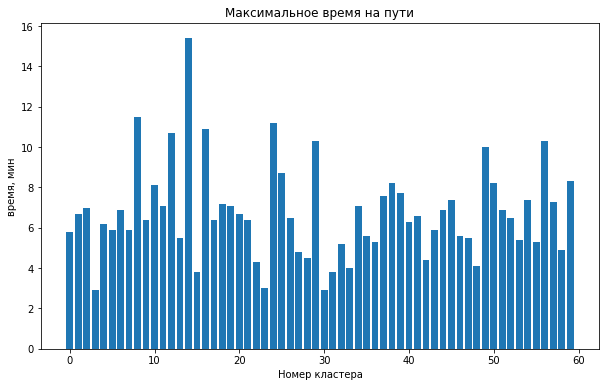

In [51]:
plt.figure(figsize=(10,6))
plt.bar(x=mean_max_time['prediction'], height=mean_max_time['max'] )
plt.title('Максимальное время на пути')
plt.xlabel('Номер кластера')
plt.ylabel('время, мин')

Можно обучить новый k-means и для новых центров вычислять расстояния от каждой точки

In [ ]:
%%time
df = ASSEMBLER.transform(df)
df = KMEANS_MODEL.transform(df)
res_df = df.select('CRASH DATE','LATITUDE','LONGITUDE', 'prediction').toPandas()
def get_dist_minute(location, cluster_center):
    """принимает на вход пару координат, строит маршрут и возвращает расстояние в минутах """
    global G
    orig = ox.get_nearest_node(G, location)
    dest = ox.get_nearest_node(G, cluster_center)
    route = ox.shortest_path(G, orig, dest, weight='travel_time')
    route_coords = [[str(G.nodes[r]['y']) for r in route],[str(G.nodes[r]['x']) for r in route] ]
    time_parts = ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')
    time_min = round(sum(time_parts)/60, 1)
    return time_min
if False:
    # Можно обучить новый k-means и для новых центров вычислять расстояния от каждой точки
    df = ASSEMBLER.transform(df)
    df = KMEANS_MODEL.transform(df)
    res_df = df.select('CRASH DATE','LATITUDE','LONGITUDE', 'prediction').toPandas()
    res_df['LOCATION'] = list(map(lambda x: tuple(x), res_df[['LATITUDE','LONGITUDE']].values))
    res_df['Cluster_center'] = res_df['prediction'].map(LABEL_CENTER_DICT)
    #для каждой точки вычислим расстояние (в минутах) от его центра 
    locations = res_df['LOCATION'].values
    cluster_center = res_df['Cluster_center'].values
    dist_minutes = []
    for i in range(len(res_df)):
        try:
            dist_minutes.append(get_dist_minute(locations[i], cluster_center[i]))
        except Exception as e:
            print(e)
            print(locations[i], cluster_center[i])
            dist_minutes.append(None)
        if i %1000==0:
            print(i)
    res_df['dist_minutes'] = dist_minutes        
    res_df.to_csv(r'/content/drive/MyDrive/res_df_2019_04_to_2019_07_30cluster.csv', index=False)
